# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [41]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.functions import col, countDistinct
from pyspark.sql.types import IntegerType
from pyspark.sql import SQLContext
from time import time

from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC, LogisticRegression,RandomForestClassifier, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, VectorAssembler, StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.stat import Statistics

import pyspark.sql.functions as F
import re
import datetime
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Creating Features") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
stack_overflow_data = 'mini_sparkify_event_data.json'
df = spark.read.json(stack_overflow_data)
#df.persist()
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [34]:
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [8]:
df.show(n=5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [9]:
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [10]:
df.count()

286500

In [12]:
df.describe('userId').show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



In [13]:
df.describe('sessionId').show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [4]:
df_valid = df.dropna(how = "any", subset = ["userId", "sessionId"])

In [5]:
df_valid.count()

286500

In [6]:
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [5]:
# Drop missing user Id
df_valid = df_valid.filter(df_valid["userId"] != "")

In [6]:
df_valid.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [6]:
df_valid.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [10]:
df_valid.select("artist").distinct().count()

17656

In [20]:
df_valid.select("auth").distinct().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [17]:
df_valid.select("gender").distinct().show()

+------+
|gender|
+------+
|     F|
|     M|
+------+



In [21]:
df_valid.describe('itemInSession').show()

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            278154|
|   mean|114.89918174824018|
| stddev|  129.851729399489|
|    min|                 0|
|    max|              1321|
+-------+------------------+



In [22]:
df_valid.describe('length').show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



In [23]:
df_valid.select("level").distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [24]:
df_valid.select("location").distinct().count()

114

In [25]:
df_valid.select("location").distinct().show(10)

+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Cleveland-Elyria, OH|
|Kingsport-Bristol...|
|New Haven-Milford...|
|Birmingham-Hoover...|
|  Corpus Christi, TX|
|         Dubuque, IA|
+--------------------+
only showing top 10 rows



In [26]:
df_valid.select("method").distinct().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [30]:
df_valid.select("song").distinct().count()

58481

In [31]:
df_valid.select("song").distinct().show(10)

+--------------------+
|                song|
+--------------------+
|Never Gonna Be Al...|
|         TULENLIEKKI|
|      Underwaterboys|
|Saor (Free)/News ...|
|               New E|
|The Geeks Were Right|
|              Heaven|
|      Call Me Manana|
|             Push It|
|Cool Monsoon (Wea...|
+--------------------+
only showing top 10 rows



In [32]:
df_valid.select("status").distinct().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [33]:
df_valid.select("userId").distinct().count()

225

In [7]:
df_valid.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [8]:
df_valid.filter("page = 'Cancellation Confirmation'").show(n=5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|
|  null|Cancelled|    Diego|     M|           56|   Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5.0 (iPh...|    32|
|  nu

In [10]:
df.select(["userId", "firstname", "page", "level", "song"]).where(df.userId == "18").collect()

[Row(userId='18', firstname='Adriel', page='Home', level='paid', song=None),
 Row(userId='18', firstname='Adriel', page='NextSong', level='paid', song='A Beggar On A Beach Of Gold'),
 Row(userId='18', firstname='Adriel', page='NextSong', level='paid', song='...slowdance On The Inside (Album Version)'),
 Row(userId='18', firstname='Adriel', page='NextSong', level='paid', song='St. Apollonia'),
 Row(userId='18', firstname='Adriel', page='NextSong', level='paid', song='Drunk Stripper'),
 Row(userId='18', firstname='Adriel', page='NextSong', level='paid', song='In League With Satan'),
 Row(userId='18', firstname='Adriel', page='Settings', level='paid', song=None),
 Row(userId='18', firstname='Adriel', page='NextSong', level='paid', song='The Quest'),
 Row(userId='18', firstname='Adriel', page='NextSong', level='paid', song='Waking The Demon'),
 Row(userId='18', firstname='Adriel', page='NextSong', level='paid', song='Why Do You Let Me Stay Here?'),
 Row(userId='18', firstname='Adriel', pag

In [6]:
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [7]:
df_valid = df_valid.withColumn("churn", flag_churn_event("page"))

In [8]:
#create spark sql to update all churned user to be 1 for churn value
df_valid.createGlobalTempView("churned_user_list")
#spark.sql("select c1.*,case when c2.userId is not null then 1 else 0 end as churn_new from global_temp.churned_user_list as c1 left join (select userId from global_temp.churned_user_list where churn = 1) as c2 on c1.userId = c2.userId").show(1)

In [9]:
# Store the output in another data frame
df_valid_new = spark.sql("select c1.*,case when c2.userId is not null then 1 else 0 end as churn_new from global_temp.churned_user_list as c1 left join (select userId from global_temp.churned_user_list where churn = 1) as c2 on c1.userId = c2.userId")
df_valid_new.show(1)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+---------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|churn_new|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+---------+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT|NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|100010|    0|        0|
+--------------------+---------+---------+------+---

In [10]:
df_valid_new=df_valid_new.drop('churn')
df_valid_new = df_valid_new.withColumnRenamed('churn_new','churn')

In [11]:
df_valid_new.take(5)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0),
 Row(artist='Francesca Battistelli', auth='Logged In', firstName='Darianna', gender='F', itemInSession=1, lastName='Carpenter', length=196.54485, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Beautiful_ Beautiful (Album)', status=200, ts=1539003736000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0

In [13]:
df_valid_new.select("userId").distinct().count()

225

+-----+-----+
|churn|Users|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



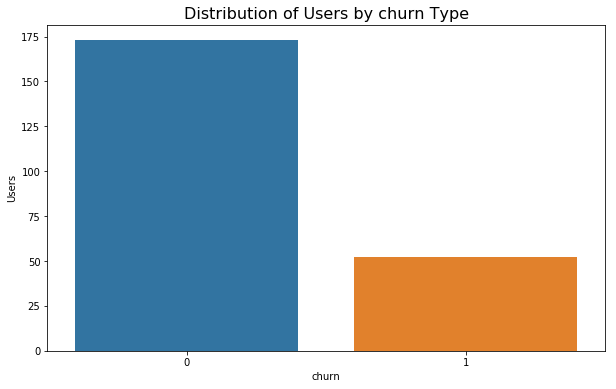

In [14]:
#Distribution of users by Churn Type
churn_counts = df_valid_new.groupBy("churn").agg(countDistinct("userId").alias("Users"))
churn_counts.show()

#sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.title('Distribution of Users by churn Type',fontsize= 16)
ax = sns.barplot(y="Users",x="churn", data=churn_counts.toPandas())

+------+-----+
|gender|Users|
+------+-----+
|     F|  104|
|     M|  121|
+------+-----+



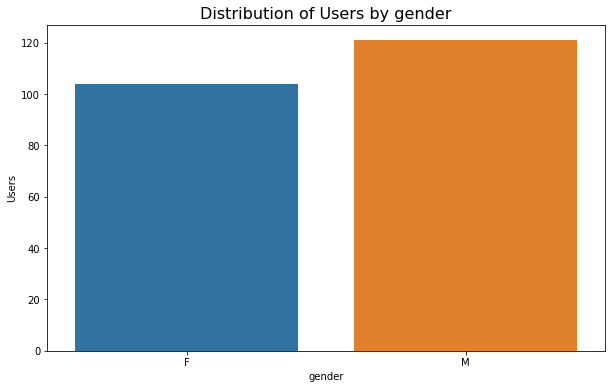

In [58]:
#Distribution of users by gender
gender_counts = df_valid_new.groupBy("gender").agg(countDistinct("userId").alias("Users"))
gender_counts.show()

#sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.title('Distribution of Users by gender',fontsize= 16)
ax = sns.barplot(y="Users", x="gender", data=gender_counts.toPandas())

+-----+-----+
|level|Users|
+-----+-----+
| free|  195|
| paid|  165|
+-----+-----+



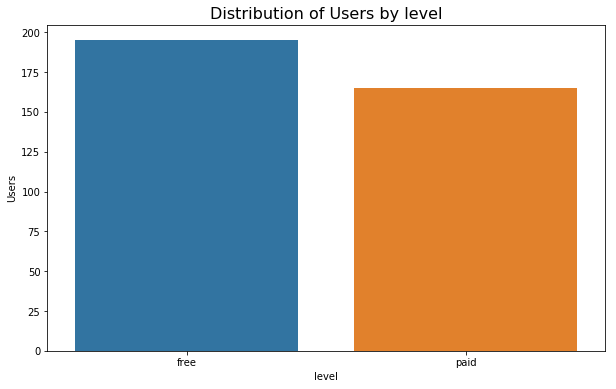

In [59]:
#Distribution of users by level
gender_counts = df_valid_new.groupBy("level").agg(countDistinct("userId").alias("Users"))
gender_counts.show()

#sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.title('Distribution of Users by level',fontsize= 16)
ax = sns.barplot(y="Users", x="level", data=gender_counts.toPandas())

Text(0,0.5,'Users')

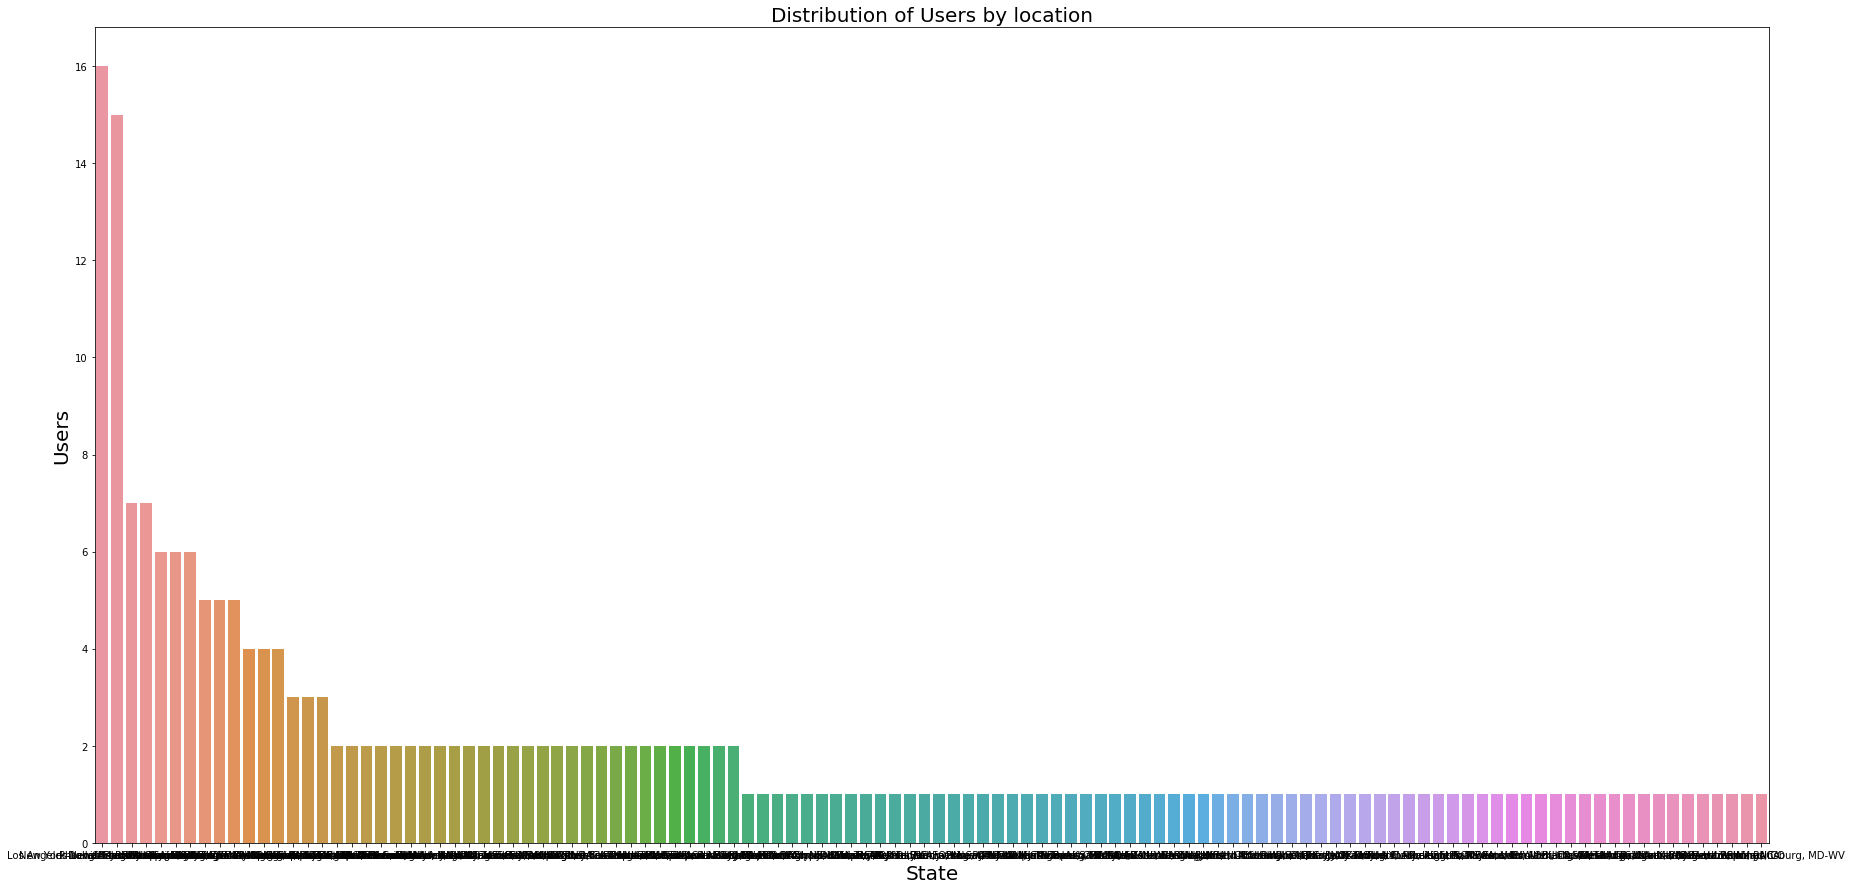

In [60]:
#Distribution of users by location
location_counts = df_valid_new.groupBy("location").agg(countDistinct("userId").alias("Users"))\
                .sort(col("Users").desc())

#sns.set(style="whitegrid")
plt.figure(figsize=(30, 15))
plt.title('Distribution of Users by location',fontsize= 20)
ax = sns.barplot(y="Users", x="location", data=location_counts.toPandas())
ax.set_xlabel("State",fontsize=20)
ax.set_ylabel("Users",fontsize=20)

+-----+------+-----+-----+------------------+
|Churn|gender|Users|total|           Percent|
+-----+------+-----+-----+------------------+
|    1|     F|   20|  104| 19.23076923076923|
|    0|     F|   84|  104| 80.76923076923077|
|    0|     M|   89|  121| 73.55371900826447|
|    1|     M|   32|  121|26.446280991735538|
+-----+------+-----+-----+------------------+



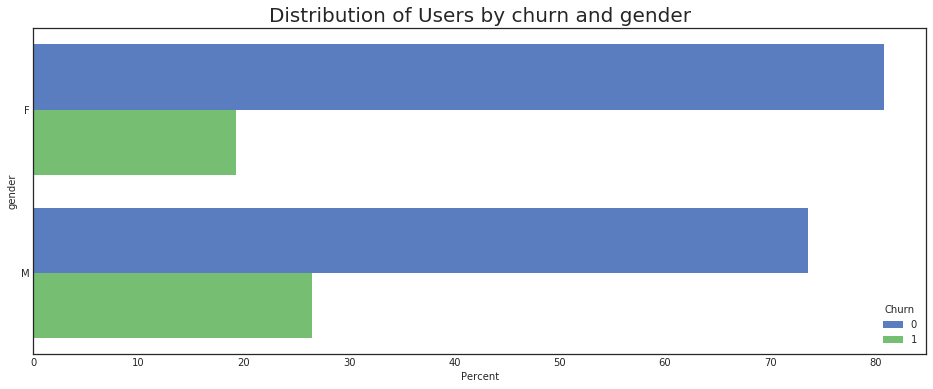

In [61]:
# Distribution of Users by Churn and Gender
churn_gender_counts = df_valid_new.groupBy(["Churn","gender"]).agg(countDistinct("userId").alias("Users"))\
                      .withColumn('total', F.sum('Users').over(Window.partitionBy('Gender')))\
                      .withColumn('Percent', F.col('Users')*100/F.col('total'))

churn_gender_counts.show()

sns.set_style("white")
plt.figure(figsize=(16, 6))
#sns.set_palette("Set1",n_colors=8, desat=.5)
sns.set_palette('muted')
plt.title('Distribution of Users by churn and gender',fontsize= 20)
ax = sns.barplot(x="Percent", y="gender", hue="Churn", data=churn_gender_counts.toPandas(),capsize=.2)

+-----+-----+-----+-----+------------------+
|Churn|level|Users|total|           Percent|
+-----+-----+-----+-----+------------------+
|    0| free|  149|  195| 76.41025641025641|
|    1| free|   46|  195| 23.58974358974359|
|    0| paid|  129|  165| 78.18181818181819|
|    1| paid|   36|  165|21.818181818181817|
+-----+-----+-----+-----+------------------+



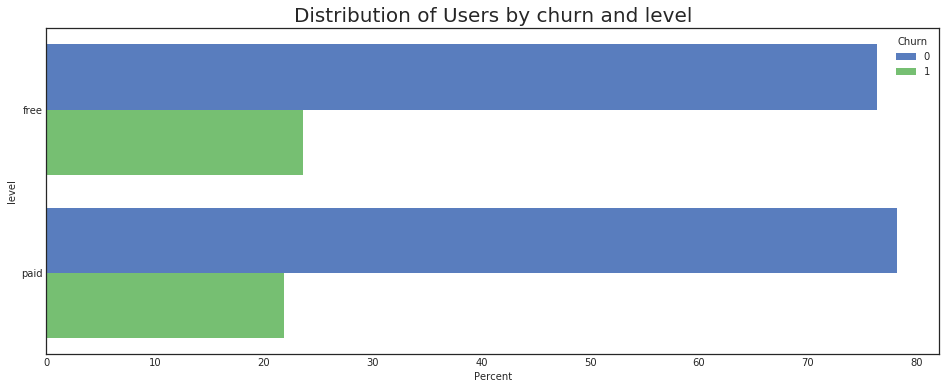

In [62]:
# Distribution of Users by Churn and level
churn_level_counts = df_valid_new.groupBy(["Churn","level"]).agg(countDistinct("userId").alias("Users"))\
                      .withColumn('total', F.sum('Users').over(Window.partitionBy('level')))\
                      .withColumn('Percent', F.col('Users')*100/F.col('total'))

churn_level_counts.show()

sns.set_style("white")
plt.figure(figsize=(16, 6))
#sns.set_palette("Set1",n_colors=8, desat=.5)
sns.set_palette('muted')
plt.title('Distribution of Users by churn and level',fontsize= 20)
ax = sns.barplot(x="Percent", y="level", hue="Churn", data=churn_level_counts.toPandas(),capsize=.2)

In [12]:
#Extract Browser Type
def get_browser(x):
    if 'Firefox' in x:
        return 'firefox'
    elif 'Safari' in x:
        if 'Chrome' in x:
            return 'chrome'
        else:
            return 'safari'
    elif 'Trident' in x:
        return 'ie'
    else:
        return np.NaN

In [13]:
def get_os(x):
    if 'Windows' in x:
        return 'windows'
    elif 'Macintosh' in x:
        return 'mac'
    elif 'Linux' in x:
        return 'linux'
    elif 'iPhone' in x:
        return 'iphone'
    elif 'iPad' in x:
        return 'ipad'
    else:
        return np.NaN

In [14]:
browser = udf(lambda x : get_browser(x))
df_valid_new = df_valid_new.withColumn('browser',browser(df.userAgent))

os = udf(lambda x : get_os(x))
df_valid_new = df_valid_new.withColumn('os',os(df.userAgent))

In [15]:
df_valid_new.show(1)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-------+------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|browser|    os|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-------+------+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT|NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|100010|    0| safari|iphone|
+--------------------+---------+

+-----+-------+-----+-----+------------------+
|Churn|browser|Users|total|           Percent|
+-----+-------+-----+-----+------------------+
|    1|firefox|   16|   50|              32.0|
|    0|firefox|   34|   50|              68.0|
|    0| chrome|   92|  117| 78.63247863247864|
|    1| chrome|   25|  117|21.367521367521366|
|    1|     ie|    1|   12| 8.333333333333334|
|    0|     ie|   11|   12| 91.66666666666667|
|    1| safari|   10|   46| 21.73913043478261|
|    0| safari|   36|   46| 78.26086956521739|
+-----+-------+-----+-----+------------------+



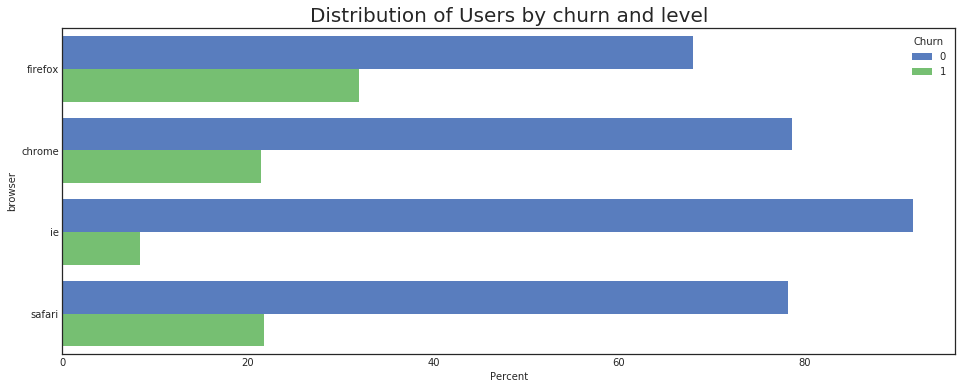

In [19]:
# Distribution of Users by Churn and browser
churn_browser_counts = df_valid_new.groupBy(["Churn","browser"]).agg(countDistinct("userId").alias("Users"))\
                      .withColumn('total', F.sum('Users').over(Window.partitionBy('browser')))\
                      .withColumn('Percent', F.col('Users')*100/F.col('total'))

churn_browser_counts.show()

sns.set_style("white")
plt.figure(figsize=(16, 6))
#sns.set_palette("Set1",n_colors=8, desat=.5)
sns.set_palette('muted')
plt.title('Distribution of Users by churn and level',fontsize= 20)
ax = sns.barplot(x="Percent", y="browser", hue="Churn", data=churn_browser_counts.toPandas(),capsize=.2)

+-----+-------+-----+-----+------------------+
|Churn|     os|Users|total|           Percent|
+-----+-------+-----+-----+------------------+
|    1| iphone|    4|   13| 30.76923076923077|
|    0| iphone|    9|   13| 69.23076923076923|
|    1|  linux|    5|   12|41.666666666666664|
|    0|  linux|    7|   12|58.333333333333336|
|    0|    mac|   67|   86| 77.90697674418605|
|    1|    mac|   19|   86|22.093023255813954|
|    0|   ipad|    3|    3|             100.0|
|    1|windows|   24|  111| 21.62162162162162|
|    0|windows|   87|  111| 78.37837837837837|
+-----+-------+-----+-----+------------------+



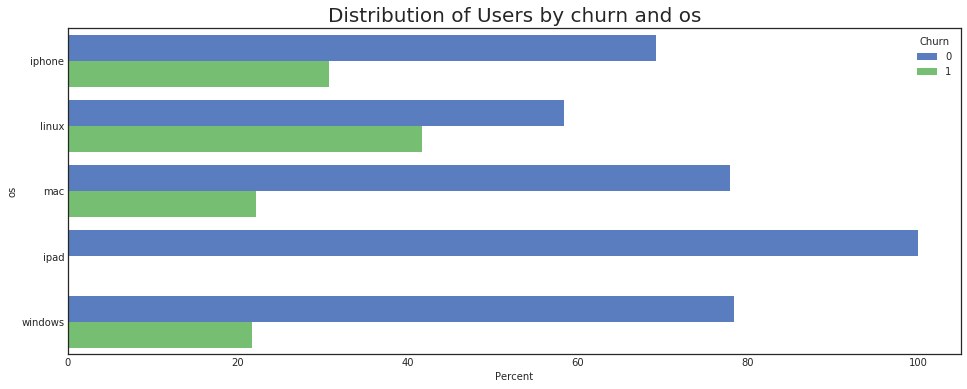

In [53]:
# Distribution of Users by Churn and os
churn_os_counts = df_valid_new.groupBy(["Churn","os"]).agg(countDistinct("userId").alias("Users"))\
                      .withColumn('total', F.sum('Users').over(Window.partitionBy('os')))\
                      .withColumn('Percent', F.col('Users')*100/F.col('total'))

churn_os_counts.show()

sns.set_style("white")
plt.figure(figsize=(16, 6))
#sns.set_palette("Set1",n_colors=8, desat=.5)
sns.set_palette('muted')
plt.title('Distribution of Users by churn and os',fontsize= 20)
ax = sns.barplot(x="Percent", y="os", hue="Churn", data=churn_os_counts.toPandas(),capsize=.2)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [16]:
# Feature 1 : Total number of  songs listened
Feature_Song_Total_Count = df_valid_new.select('userId', 'song').groupBy('userId').count().withColumnRenamed('count', 'total_songs')
Feature_Song_Total_Count.show(5)

+------+-----------+
|userId|total_songs|
+------+-----------+
|100010|        381|
|200002|        474|
|   125|         11|
|   124|       4825|
|    51|       2464|
+------+-----------+
only showing top 5 rows



In [17]:
# Feature 2 : Number of thumbs up
Feature_Total_ThumbsUp = df_valid_new.select('userId', 'page').where(df_valid_new.page == 'Thumbs Up').groupBy('userId').count().withColumnRenamed('count', 'total_thumbs_up')
Feature_Total_ThumbsUp.show(5)

+------+---------------+
|userId|total_thumbs_up|
+------+---------------+
|100010|             17|
|200002|             21|
|   124|            171|
|    51|            100|
|     7|              7|
+------+---------------+
only showing top 5 rows



In [18]:
# Feature 3 : Number of thumbs down
Feature_Total_ThumbsDown = df_valid_new.select('userId', 'page').where(df_valid_new.page == 'Thumbs Down').groupBy('userId').count().withColumnRenamed('count', 'total_thumbs_down')
Feature_Total_ThumbsDown.show(5)

+------+-----------------+
|userId|total_thumbs_down|
+------+-----------------+
|100010|                5|
|200002|                6|
|   124|               41|
|    51|               21|
|     7|                1|
+------+-----------------+
only showing top 5 rows



In [19]:
# Feature 4 : Total time since registration
Feature_RegistrationTime = df_valid_new.select('userId', 'registration', 'ts').withColumn('tot_lifetime', (df_valid_new.ts - df_valid_new.registration))\
    .groupBy('userId').agg({'tot_lifetime' : 'max'})\
    .withColumnRenamed('max(tot_lifetime)', 'tot_lifetime')\
    .select('userId', (col('tot_lifetime')/1000/3600/24).alias('total_lifetime'))
Feature_RegistrationTime.show(5)

+------+------------------+
|userId|    total_lifetime|
+------+------------------+
|100010|  55.6436574074074|
|200002| 70.07462962962963|
|   125| 71.31688657407408|
|   124|131.55591435185184|
|    51|19.455844907407407|
+------+------------------+
only showing top 5 rows



In [20]:
# Feature 5 : Total length of listening utilizing all services
Feature_Total_ListenTime= df_valid_new.select("userId", 'length').groupBy('userId').sum().withColumnRenamed('sum(length)', 'total_listen_time')
Feature_Total_ListenTime.show(5)

+------+------------------+
|userId| total_listen_time|
+------+------------------+
|100010| 66940.89735000003|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|   124|1012312.0927899999|
|    51| 523275.8428000004|
+------+------------------+
only showing top 5 rows



In [21]:
# Feature 6 : Total number of friends
Feature_Total_Friends_Count= df_valid_new.select('userId', 'page').where(df_valid_new.page == 'Add Friend').groupBy('userId').count().withColumnRenamed('count', 'total_friends')
Feature_Total_Friends_Count.show(5)

+------+-------------+
|userId|total_friends|
+------+-------------+
|100010|            4|
|200002|            4|
|   124|           74|
|    51|           28|
|     7|            1|
+------+-------------+
only showing top 5 rows



In [22]:
# Feature 7 : Gender of the user
Feature_Gender = df_valid_new.select('userId', 'gender').dropDuplicates().replace(['F', 'M'], ['0', '1'], 'gender').select('userId', col('gender').cast('int'))
Feature_Gender.show(5)

+------+------+
|userId|gender|
+------+------+
|100010|     0|
|200002|     1|
|   125|     1|
|   124|     0|
|    51|     1|
+------+------+
only showing top 5 rows



In [23]:
# Feature 8 : Total number of songs listened per session
Feature_Avg_Played_Songs = df_valid_new.where('page == "NextSong"').groupby(['userId', 'sessionId']).count().groupby('userId')\
          .agg({'count' : 'avg'}).withColumnRenamed('avg(count)', 'avg_played_songs')

Feature_Avg_Played_Songs.show(5)

+------+------------------+
|userId|  avg_played_songs|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|   124|145.67857142857142|
|    51|             211.1|
+------+------------------+
only showing top 5 rows



In [24]:
# Feature 9 : Total number of artists the user has listened to
Feature_Total_Artist_Played = df_valid_new.filter(df.page == "NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()\
         .withColumnRenamed("count", "total_artist_played")
Feature_Total_Artist_Played.show(5)

+------+-------------------+
|userId|total_artist_played|
+------+-------------------+
|100010|                252|
|200002|                339|
|   125|                  8|
|   124|               2232|
|    51|               1385|
+------+-------------------+
only showing top 5 rows



In [25]:
# setting the churn label for our model
Label = df_valid_new.select('userId', col('churn').alias('label')).dropDuplicates()
Label.show(5)

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
+------+-----+
only showing top 5 rows



In [26]:
# Combining all features with the target churn label
Final_data = Feature_Song_Total_Count.join(Feature_Total_ThumbsUp, 'userId', 'inner').join(Feature_Total_ThumbsDown, 'userId', 'inner').join(Feature_RegistrationTime, 'userId', 'inner')\
             .join(Feature_Total_ListenTime, 'userId', 'inner').join(Feature_Total_Friends_Count, 'userId', 'inner').join(Feature_Gender , 'userId', 'inner')\
             .join(Feature_Avg_Played_Songs, 'userId', 'inner').join(Feature_Total_Artist_Played, 'userId', 'inner').join(Label, 'userId', 'inner').drop('userId')

Final_data.show(5)

+-----------+---------------+-----------------+------------------+------------------+-------------+------+------------------+-------------------+-----+
|total_songs|total_thumbs_up|total_thumbs_down|    total_lifetime| total_listen_time|total_friends|gender|  avg_played_songs|total_artist_played|label|
+-----------+---------------+-----------------+------------------+------------------+-------------+------+------------------+-------------------+-----+
|        381|             17|                5|  55.6436574074074| 66940.89735000003|            4|     0|39.285714285714285|                252|    0|
|        474|             21|                6| 70.07462962962963| 94008.87593999993|            4|     1|              64.5|                339|    0|
|       4825|            171|               41|131.55591435185184|1012312.0927899999|           74|     0|145.67857142857142|               2232|    0|
|       2464|            100|               21|19.455844907407407| 523275.8428000004|   

In [25]:
Final_data.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   43|
|    0|  150|
+-----+-----+



In [27]:
features = ['total_songs','total_thumbs_up','total_thumbs_down','total_lifetime','total_listen_time','total_friends','gender','avg_played_songs','total_artist_played']


In [28]:
#Vectorize and Scale
assembler = VectorAssembler(inputCols=features, outputCol="NumFeatures")
Final_data = assembler.transform(Final_data)
Final_data.show(5)

+-----------+---------------+-----------------+------------------+------------------+-------------+------+------------------+-------------------+-----+--------------------+
|total_songs|total_thumbs_up|total_thumbs_down|    total_lifetime| total_listen_time|total_friends|gender|  avg_played_songs|total_artist_played|label|         NumFeatures|
+-----------+---------------+-----------------+------------------+------------------+-------------+------+------------------+-------------------+-----+--------------------+
|        381|             17|                5|  55.6436574074074| 66940.89735000003|            4|     0|39.285714285714285|                252|    0|[381.0,17.0,5.0,5...|
|        474|             21|                6| 70.07462962962963| 94008.87593999993|            4|     1|              64.5|                339|    0|[474.0,21.0,6.0,7...|
|       4825|            171|               41|131.55591435185184|1012312.0927899999|           74|     0|145.67857142857142|          

In [29]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledFeatures")
scaler_model = scaler.fit(Final_data)
Final_data = scaler_model.transform(Final_data)

In [30]:
#Spark dataframes are not used like that in Spark ML; all your features need to be vectors in a single column, usually named features
data = Final_data.select(Final_data.label,Final_data.ScaledFeatures.alias("features"))
data.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[0.28303716272111...|
|    0|[0.35212497409397...|
|    0|[3.58439451477521...|
|    1|[1.83045556153494...|
|    0|[0.14931881812845...|
+-----+--------------------+
only showing top 5 rows



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [31]:
train, test = data.randomSplit([0.75, 0.25], seed=42)

In [32]:
# Approach 1 : Random Forest Classifier
rf_clf = RandomForestClassifier()

f1_evaluation = MulticlassClassificationEvaluator(metricName = 'f1')
param_grid = ParamGridBuilder().build()

rf_crossval = CrossValidator(estimator = rf_clf, estimatorParamMaps = param_grid, evaluator = f1_evaluation, numFolds = 2)

In [33]:
rf_model = rf_crossval.fit(train)
rf_predict = rf_model.transform(test)

evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("Random Forest Metrics :")
print("The F-1 Score is {}".format(evaluator.evaluate(rf_predict , {evaluator.metricName : "accuracy"})))
print("The accuracy is {}".format(evaluator.evaluate(rf_predict , {evaluator.metricName : "f1"})))


Random Forest Metrics :
The F-1 Score is 0.8292682926829268
The accuracy is 0.7919623677842128


In [34]:
#Approach 2: Logistic regression
lr_clf = LogisticRegression(maxIter=10,regParam=0.0,elasticNetParam=0)

f1_evaluation = MulticlassClassificationEvaluator(metricName = 'f1')
param_grid = ParamGridBuilder().build()

lr_crossval = CrossValidator(estimator = lr_clf, estimatorParamMaps = param_grid, evaluator = f1_evaluation, numFolds = 2)

In [35]:
lr_model = lr_crossval.fit(train)
lr_predict = lr_model.transform(test)

evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("Logistic Regression Metrics :")
print("The F-1 Score is {}".format(evaluator.evaluate(lr_predict , {evaluator.metricName : "accuracy"})))
print("The accuracy is {}".format(evaluator.evaluate(lr_predict , {evaluator.metricName : "f1"})))

Logistic Regression Metrics :
The F-1 Score is 0.8048780487804879
The accuracy is 0.7716745234679236


In [36]:
#Approach 3: SVM
svm_clf = LinearSVC(maxIter=10)
f1_evaluation = MulticlassClassificationEvaluator(metricName = 'f1')
param_grid = ParamGridBuilder().build()

svm_crossval = CrossValidator(estimator = svm_clf, estimatorParamMaps = param_grid, evaluator = f1_evaluation, numFolds = 2)

In [37]:
svm_model = svm_crossval.fit(train)
svm_predict = svm_model.transform(test)

evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("Support Vector Machine Metrics :")
print("The F-1 Score is {}".format(evaluator.evaluate(svm_predict , {evaluator.metricName : "accuracy"})))
print("The accuracy is {}".format(evaluator.evaluate(svm_predict , {evaluator.metricName : "f1"})))

Support Vector Machine Metrics :
The F-1 Score is 0.7560975609756098
The accuracy is 0.6510840108401085


In [38]:
#Gradient Boosting Trees Classification
gbt_clf = GBTClassifier(maxIter=10,seed=42)
f1_evaluation = MulticlassClassificationEvaluator(metricName = 'f1')

param_grid = ParamGridBuilder().build()

gbt_crossval = CrossValidator(estimator = gbt_clf, estimatorParamMaps = param_grid, evaluator = f1_evaluation, numFolds = 2)

In [39]:
gbt_model = gbt_crossval.fit(train)
gbt_predict = gbt_model.transform(test)

evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("Support Vector Machine Metrics :")
print("The F-1 Score is {}".format(evaluator.evaluate(gbt_predict , {evaluator.metricName : "accuracy"})))
print("The accuracy is {}".format(evaluator.evaluate(gbt_predict , {evaluator.metricName : "f1"})))

Support Vector Machine Metrics :
The F-1 Score is 0.7317073170731707
The accuracy is 0.7267762903192941


In [43]:
test.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[0.35212497409397...|
|    0|[3.58439451477521...|
|    0|[1.69227993878920...|
|    0|[0.21692087011696...|
|    0|[3.16243884961618...|
+-----+--------------------+
only showing top 5 rows



In [ ]:
#From the results above, we can see that random forest is the best model as it has the highest F1 Score of 0.83.

In [ ]:
#The following are hyper-parameters used for grid search in the ML pipeline. 
"""
Random Forest
impurity: entropy, gini
maxDepth: 2, 4, 6, 8
"""

In [48]:
#Modelling with grid search of hyperparameters
rf = RandomForestClassifier()
paramGrid_rf = ParamGridBuilder()\
    .addGrid(rf.impurity,['entropy', 'gini']) \
    .addGrid(rf.maxDepth,[2, 4, 6, 8]) \
    .build()
f1_evaluation = MulticlassClassificationEvaluator(metricName = 'f1')
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid_rf,
                          evaluator=f1_evaluation,
                          numFolds=2)  # use 3+ folds in practice.
cvModel = crossval.fit(train)
#prediction = cvModel.transform(test)
#selected = prediction.select("features", "label", "prediction")
#for row in selected.collect():
#    print(row)
bestModel = cvModel.bestModel
print ('Best Param (maxDepth): ', bestModel._java_obj.getMaxDepth())


Best Param (maxDepth):  6


In [ ]:
#Plot feature importance

In [51]:
print ('Feature Importance:',bestModel.featureImportances)

Feature Importance: (9,[0,1,2,3,4,5,6,7,8],[0.135662611371,0.0627473477311,0.102158868574,0.286296201743,0.0827713019501,0.143793762784,0.0501431220927,0.0846189649742,0.05180781878])


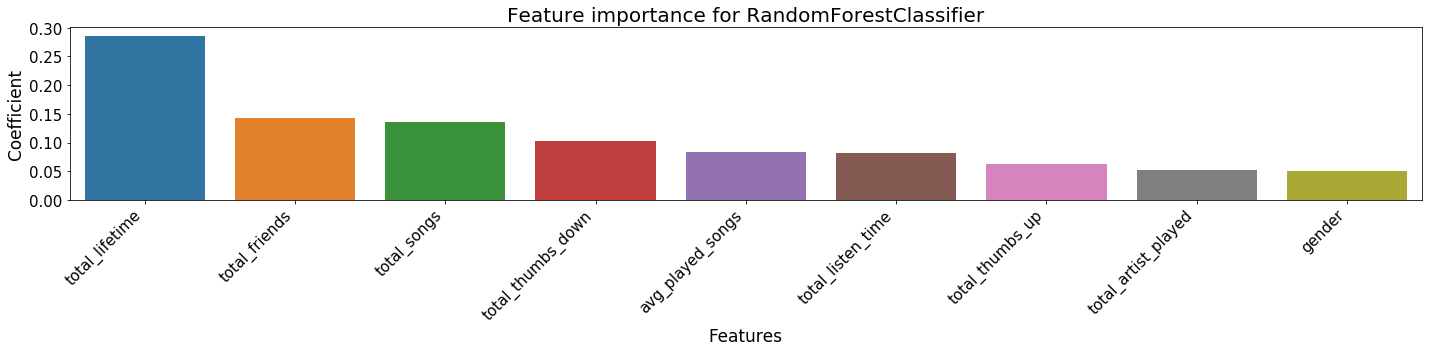

In [55]:
feature_cols = Final_data.columns[:-1]
feature_ind = bestModel.featureImportances.indices.tolist()
feature_name = [feature_cols[ind] for ind in feature_ind]
feature_coef = bestModel.featureImportances.values.tolist()
feature_coef_df = pd.DataFrame(list(zip(feature_name, feature_coef)), columns=['Feature', 'Coefficient'])\
            .sort_values('Coefficient', ascending=False)
plt.figure(figsize=(20,5))
sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df)
plt.title('Feature importance for {}'.format('RandomForestClassifier'), fontsize=20)
plt.xlabel('Features', fontsize=17)
plt.ylabel('Coefficient', fontsize=17)
plt.xticks(rotation=45, ha='right', fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('feature_importance_{}.png'.format('RandomForestClassifier'))
plt.show()

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.